Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


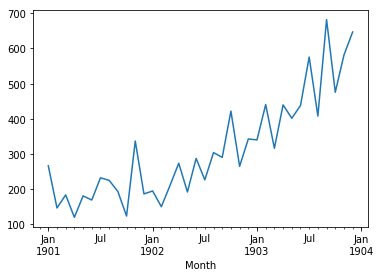

In [4]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv',header=0, parse_dates=[0],
                  index_col=0, squeeze=True, date_parser=parser)

# summarize first few rows
print(series.head())

# line plot
series.plot()
pyplot.show()

# Vary Training Epochs

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from math import sqrt
import matplotlib
from matplotlib import pyplot
import numpy

In [6]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [7]:
# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

In [8]:
# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]

    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 4
        train_trimmed = train_scaled[2:, :]
        model = fit_model(train_trimmed, batch_size, epochs, neurons)
        
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            
            # store forecast
            predictions.append(yhat)
            
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
        
    return error_scores

1) Test RMSE: 105.180
2) Test RMSE: 126.526
3) Test RMSE: 113.423
4) Test RMSE: 110.175
5) Test RMSE: 175.775
6) Test RMSE: 140.269
7) Test RMSE: 94.609
8) Test RMSE: 108.487
9) Test RMSE: 149.486
10) Test RMSE: 112.318
11) Test RMSE: 146.065
12) Test RMSE: 219.757
13) Test RMSE: 140.900
14) Test RMSE: 118.093
15) Test RMSE: 163.715
16) Test RMSE: 121.988
17) Test RMSE: 143.262
18) Test RMSE: 156.322
19) Test RMSE: 106.352
20) Test RMSE: 151.852
21) Test RMSE: 138.354
22) Test RMSE: 110.274
23) Test RMSE: 120.144
24) Test RMSE: 143.049
25) Test RMSE: 94.719
26) Test RMSE: 142.562
27) Test RMSE: 111.028
28) Test RMSE: 113.224
29) Test RMSE: 135.336
30) Test RMSE: 141.481
1) Test RMSE: 101.893
2) Test RMSE: 105.580
3) Test RMSE: 136.259
4) Test RMSE: 139.947
5) Test RMSE: 163.925
6) Test RMSE: 93.895
7) Test RMSE: 135.188
8) Test RMSE: 93.807
9) Test RMSE: 110.078
10) Test RMSE: 107.398
11) Test RMSE: 135.136
12) Test RMSE: 96.642
13) Test RMSE: 135.999
14) Test RMSE: 153.034
15) Test RM

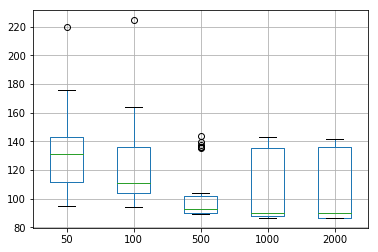

In [9]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# experiment
repeats = 30
results = DataFrame()
lag = 1
neurons = 1

# vary training epochs
epochs = [50, 100, 500, 1000, 2000]

for e in epochs:
    results[str(e)] = experiment(repeats, series, e, lag, neurons)
    
# summarize results
print(results.describe())

# save boxplot
results.boxplot()

In [10]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from math import sqrt
import matplotlib
from matplotlib import pyplot
import numpy

In [11]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        
        # invert differencing
        yhat = yhat + raw_data[i]
        
        # store forecast
        predictions.append(yhat)
        
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

In [12]:
# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

0) TrainRMSE=90.341007, TestRMSE=135.137420
1) TrainRMSE=66.140630, TestRMSE=86.651684
2) TrainRMSE=66.139545, TestRMSE=86.625713
3) TrainRMSE=90.341007, TestRMSE=136.035226
4) TrainRMSE=90.341007, TestRMSE=135.834052
5) TrainRMSE=66.279492, TestRMSE=87.395160
6) TrainRMSE=90.341007, TestRMSE=140.826633
7) TrainRMSE=60.276749, TestRMSE=90.091470
8) TrainRMSE=66.136544, TestRMSE=86.534614
9) TrainRMSE=66.263536, TestRMSE=87.364036


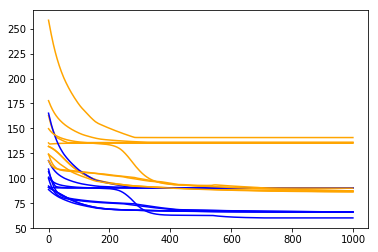

In [13]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 1000
    n_neurons = 1
    n_lag = 1
    
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))

# entry point
run()

# Vary Hidden Layer Neurons

1) Test RMSE: 138.128
2) Test RMSE: 90.141
3) Test RMSE: 135.321
4) Test RMSE: 135.137
5) Test RMSE: 90.078
6) Test RMSE: 87.187
7) Test RMSE: 137.894
8) Test RMSE: 90.081
9) Test RMSE: 90.069
10) Test RMSE: 90.100
11) Test RMSE: 90.071
12) Test RMSE: 90.057
13) Test RMSE: 135.790
14) Test RMSE: 90.921
15) Test RMSE: 137.076
16) Test RMSE: 86.747
17) Test RMSE: 136.140
18) Test RMSE: 90.048
19) Test RMSE: 92.168
20) Test RMSE: 141.837
21) Test RMSE: 86.580
22) Test RMSE: 135.944
23) Test RMSE: 86.671
24) Test RMSE: 89.852
25) Test RMSE: 135.137
26) Test RMSE: 136.573
27) Test RMSE: 86.645
28) Test RMSE: 86.584
29) Test RMSE: 91.306
30) Test RMSE: 86.634
1) Test RMSE: 102.065
2) Test RMSE: 136.524
3) Test RMSE: 90.070
4) Test RMSE: 93.124
5) Test RMSE: 91.405
6) Test RMSE: 101.838
7) Test RMSE: 91.442
8) Test RMSE: 102.941
9) Test RMSE: 92.873
10) Test RMSE: 136.324
11) Test RMSE: 95.416
12) Test RMSE: 103.582
13) Test RMSE: 87.372
14) Test RMSE: 135.759
15) Test RMSE: 84.477
16) Test R

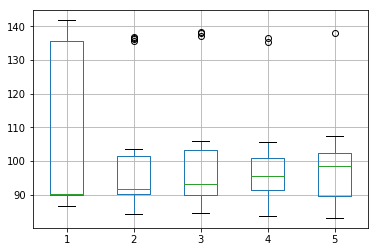

In [14]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# experiment
repeats = 30
results = DataFrame()
lag = 1
epochs = 1000

# vary neurons
neurons = [1, 2, 3, 4, 5]
for n in neurons:
    results[str(n)] = experiment(repeats, series, epochs, lag, n)
    
# summarize results
print(results.describe())

# save boxplot
results.boxplot()

0) TrainRMSE=65.127010, TestRMSE=95.559401
1) TrainRMSE=60.546592, TestRMSE=89.567500
2) TrainRMSE=60.841107, TestRMSE=89.711234
3) TrainRMSE=60.694797, TestRMSE=89.175116
4) TrainRMSE=66.138417, TestRMSE=86.820177
5) TrainRMSE=58.433361, TestRMSE=102.619428
6) TrainRMSE=58.592284, TestRMSE=103.860168
7) TrainRMSE=62.704076, TestRMSE=93.558309
8) TrainRMSE=65.198109, TestRMSE=92.969851
9) TrainRMSE=62.831334, TestRMSE=91.407851


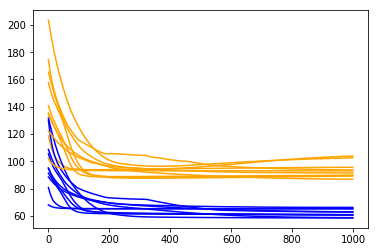

In [16]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 1000
    n_neurons = 3
    n_lag = 1
    
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
        
run()

# Vary Hidden Layer Neurons with Lag

1) Test RMSE: 138.845
2) Test RMSE: 137.963
3) Test RMSE: 135.414
4) Test RMSE: 136.482
5) Test RMSE: 135.485
6) Test RMSE: 137.422
7) Test RMSE: 92.603
8) Test RMSE: 90.870
9) Test RMSE: 135.659
10) Test RMSE: 139.500
11) Test RMSE: 140.091
12) Test RMSE: 138.261
13) Test RMSE: 135.961
14) Test RMSE: 136.243
15) Test RMSE: 138.322
16) Test RMSE: 92.130
17) Test RMSE: 92.602
18) Test RMSE: 135.557
19) Test RMSE: 137.769
20) Test RMSE: 135.541
21) Test RMSE: 137.364
22) Test RMSE: 136.470
23) Test RMSE: 92.376
24) Test RMSE: 91.117
25) Test RMSE: 92.585
26) Test RMSE: 92.017
27) Test RMSE: 138.481
28) Test RMSE: 137.462
29) Test RMSE: 136.110
30) Test RMSE: 135.426
1) Test RMSE: 117.627
2) Test RMSE: 116.380
3) Test RMSE: 107.068
4) Test RMSE: 77.113
5) Test RMSE: 84.935
6) Test RMSE: 123.837
7) Test RMSE: 106.473
8) Test RMSE: 80.932
9) Test RMSE: 93.435
10) Test RMSE: 120.677
11) Test RMSE: 121.727
12) Test RMSE: 122.515
13) Test RMSE: 102.100
14) Test RMSE: 102.749
15) Test RMSE: 69.

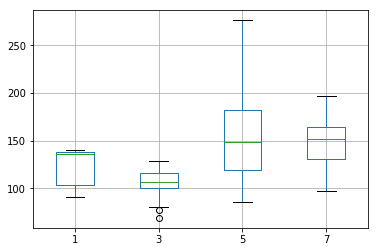

In [17]:
# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 2
        model = fit_model(train_scaled, batch_size, epochs, neurons)
        
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            
            # store forecast
            predictions.append(yhat)
            
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
        
    return error_scores

# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# experiment
repeats = 30
results = DataFrame()
epochs = 1000

# vary neurons
neurons = [1, 3, 5, 7]
for n in neurons:
    results[str(n)] = experiment(repeats, series, epochs, n, n)
    
# summarize results
print(results.describe())

# save boxplot
results.boxplot()

0) TrainRMSE=52.936421, TestRMSE=110.363601
1) TrainRMSE=60.999607, TestRMSE=103.885275
2) TrainRMSE=47.320151, TestRMSE=89.449355
3) TrainRMSE=56.991788, TestRMSE=105.834216
4) TrainRMSE=44.627253, TestRMSE=106.058653
5) TrainRMSE=53.908495, TestRMSE=101.181546
6) TrainRMSE=45.580108, TestRMSE=107.737932
7) TrainRMSE=90.243905, TestRMSE=125.343957
8) TrainRMSE=52.987812, TestRMSE=120.722573
9) TrainRMSE=50.683432, TestRMSE=117.745776


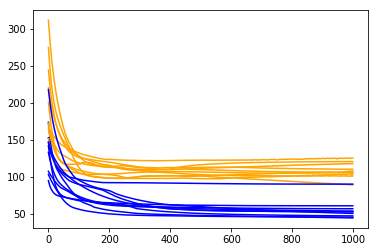

In [18]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 2
    n_epochs = 1000
    n_neurons = 3
    n_lag = 3
    
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))

run()